In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style, rcParams
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import xgboost.sklearn as xgb
import gensim
import seaborn as sns
import pickle

style.use('ggplot')
rcParams['font.size'] = 14
rcParams['legend.fontsize'] = 'small'
rcParams['figure.titlesize'] = 'large'

In [8]:
df = pd.read_csv('../data/train.csv')

In [11]:
df

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"
...,...,...,...
10235,3,There are a larger number of shark attacks in ...,"animals,elections"
10236,3,Democrats have now become the party of the [At...,elections
10237,2,Says an alternative to Social Security that op...,"retirement,social-security"
10238,1,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy"


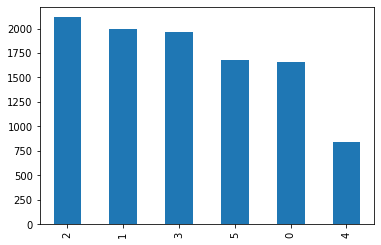

In [7]:
df.Labels.value_counts().plot(kind='bar');

# Half-True - 2
# False - 1
# Mostly-True - 3
# True - 5
# Barely-True - 0
# Not-Known - 4

In [20]:
X = df['Text']
y = df['Labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [21]:
stopwords_ = set(stopwords.words('english'))

In [27]:
tfidf = TfidfVectorizer(stop_words=stopwords_)
words_train = tfidf.fit_transform(X_train).toarray()
words_test = tfidf.transform(X_test).toarray()
feats = tfidf.get_feature_names()

In [28]:
words_train.shape, words_test.shape

((8192, 10887), (2048, 10887))

In [ ]:
nmf = NMF(n_components=3661)
W = nmf.fit_transform(words)
H = nmf.components_

In [ ]:
W.shape

In [ ]:
nmf.reconstruction_err_

In [ ]:
lst = []
for i in range(21,31):
    nmf = NMF(n_components=i)
    nmf.fit(words)
    lst.append(nmf.reconstruction_err_)

plt.plot(range(21,31),lst)

In [ ]:
plt.plot(range(21,31),lst)

In [29]:
pca = PCA()
pca.fit(words_train)

PCA()

In [53]:
filename = '../models/pca_model.sav'
pickle.dump(pca, open(filename, 'wb'))

In [34]:
words_tr_pca = pca.transform(words_train)
words_tst_pca = pca.transform(words_test)

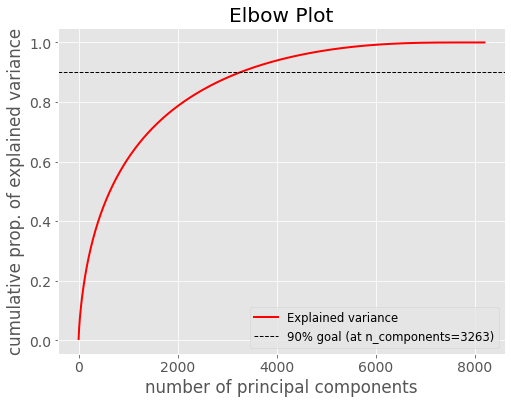

In [69]:
total_variance = np.sum(pca.explained_variance_)
cum_variance = np.cumsum(pca.explained_variance_)
prop_var_expl = cum_variance/total_variance
idx = np.argwhere(prop_var_expl > 0.9)[0][0] + 1

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl, color='red', linewidth=2, label='Explained variance')
ax.axhline(0.9, label=f'90% goal (at n_components={idx})', linestyle='--', color="black", linewidth=1)
ax.set_ylabel('cumulative prop. of explained variance')
ax.set_xlabel('number of principal components')
ax.set_title('Elbow Plot')
ax.legend()
plt.savefig('../images/pca_cumulsum_elbow.png');

In [63]:
np.argwhere(prop_var_expl > 0.9)[0][0]

3262

In [32]:
prop_var_expl[3262]

0.9000272792363343

In [70]:
words.shape

(10240, 12061)

In [37]:
comp = 3263
rf = RandomForestClassifier()
rf.fit(words_tr_pca[:,:comp], y_train)
y_pred = rf.predict(words_tst_pca[:,:comp])

In [61]:
filename = '../models/rf1_6classes.sav'
pickle.dump(rf, open(filename, 'wb'))

In [60]:
# print(f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(classification_report(y_train, rf.predict(words_tr_pca[:,:comp])))
rf.score(words_tr_pca[:,:comp], y_train)

              precision    recall  f1-score   support

           0       0.24      0.14      0.17       331
           1       0.25      0.34      0.29       399
           2       0.22      0.40      0.29       423
           3       0.26      0.29      0.27       392
           4       1.00      0.03      0.06       168
           5       0.27      0.09      0.14       335

    accuracy                           0.24      2048
   macro avg       0.37      0.21      0.20      2048
weighted avg       0.31      0.24      0.22      2048

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1323
           1       1.00      1.00      1.00      1596
           2       1.00      1.00      1.00      1691
           3       1.00      1.00      1.00      1570
           4       1.00      1.00      1.00       671
           5       1.00      1.00      1.00      1341

    accuracy                           1.00      8192
   macro avg       1.00

0.99951171875

In [41]:
confusion_matrix(y_test, y_pred)

array([[ 46,  84, 116,  65,   0,  20],
       [ 40, 134, 135,  73,   0,  17],
       [ 39, 111, 170,  89,   0,  14],
       [ 26,  86, 143, 112,   0,  25],
       [ 19,  46,  68,  22,   5,   8],
       [ 25,  75, 128,  76,   0,  31]])

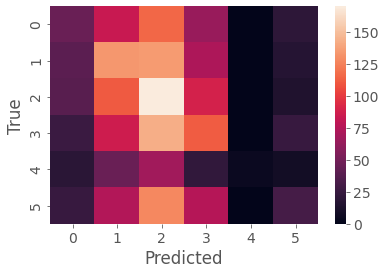

In [71]:
sns.heatmap(confusion_matrix(y_test, y_pred))
plt.xlabel('Predicted')
plt.ylabel('True');

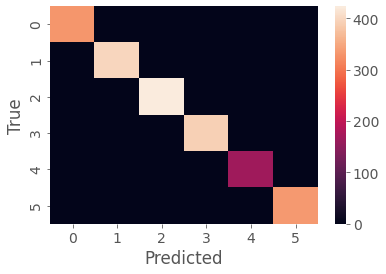

In [72]:
# if it were a perfect prediction

sns.heatmap(confusion_matrix(y_test, y_test))
plt.xlabel('Predicted')
plt.ylabel('True');

Try dropping the not known class (class 4) and rerun